# Compare how well the annealing procedure performs when rescaling/normalizing as suggested in the SVD approach
First, we need to add the parent folder to the path to use all out packages

In [1]:
import sys
sys.path
sys.path.append("..")

Now, we can import everything as usual

In [2]:
# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500, edgeitems=10)
# example imports
import example
from utils import root_utils
# plotting imports
import pylab as plt
%matplotlib inline
# Set up logger to print in the notebook
import sys, logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

Welcome to JupyROOT 6.23/01


## Initializiation
Initialize data

In [3]:
# toy generation
nbins = 40
# Generate initial distribution and response matrix
xini, bini, Adet = example.maker.generate_initial_samples(nbins)
# Generate test distribution (what is measured in the experiment)
datatrue, data, statcov = example.maker.generate_test_samples(nbins)

# Map ROOT objects to numpy arrays
xinipy, xinipy_edges = root_utils.histogram_to_python(xini)
binipy, binipy_edges = root_utils.histogram_to_python(bini)
Adetpy_events, Adetpy_edges = root_utils.histogram_to_python(Adet)

# Data
datapy, datapy_edges = root_utils.histogram_to_python(data)
# Data "truth" distribution to test the unfolding
datatruepy, datatruepy_edges = root_utils.histogram_to_python(datatrue)
# Statistical covariance matrix
statcovpy, statcovpy_edges = root_utils.histogram_to_python(statcov)
# Turn Adetpy from number of events to probabilities (to use it with quantum annealing)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

## Rescaling
Get a rescaled and normalized copy of the data to compare

In [4]:
# In order to normalize the unknowns, we will use Aij as the matrix of events (Adetpy_events) which we already have. So now, we just need to rescale the equations to get a balanced system:
rescaled_datapy = np.copy(datapy)
rescaled_A = np.copy(Adetpy_events)
for i in range(len(statcovpy)):
    error = statcovpy[i][i]
    if error != 0:
        # Rescale b
        rescaled_datapy[i] /= np.sqrt(error)
        # Rescale A
        rescaled_A[i,:] /= np.sqrt(error)
# create a vector full of ones to encode
datatruepy_for_encoding = datatruepy/xinipy

## Unfold

In [5]:
# annealing unfolder
from unfolders.annealing import QUBOUnfolder, backends

### Simulated Quantum Annealing
First, compare simulated Quantum annealing

In [6]:
# Unfold the rescaled histograms
unfolder_rescaled = QUBOUnfolder(
    datatruepy_for_encoding, rescaled_A, rescaled_datapy, n_bits=4, weight_regularization=0.8
)
# Unfold
x_unfolded = unfolder_rescaled.solve(
    backends.SimulatedQuantumAnnealingBackend(100)
)
# Descale and denormalize
x_unfolded_scaling = np.multiply(x_unfolded, xinipy)

In [7]:
# Unfold the normal histograms
# adding +1 to avoid division over zero
unfolder = QUBOUnfolder(
    datatruepy+1, Adetpy, datapy, n_bits=4, weight_regularization=0.5
)
# Unfold
x_unfolded_normal = unfolder.solve(
    backends.SimulatedQuantumAnnealingBackend(100)
)

Plot to compare

Text(0.5, 1.0, 'Without re-scaling')

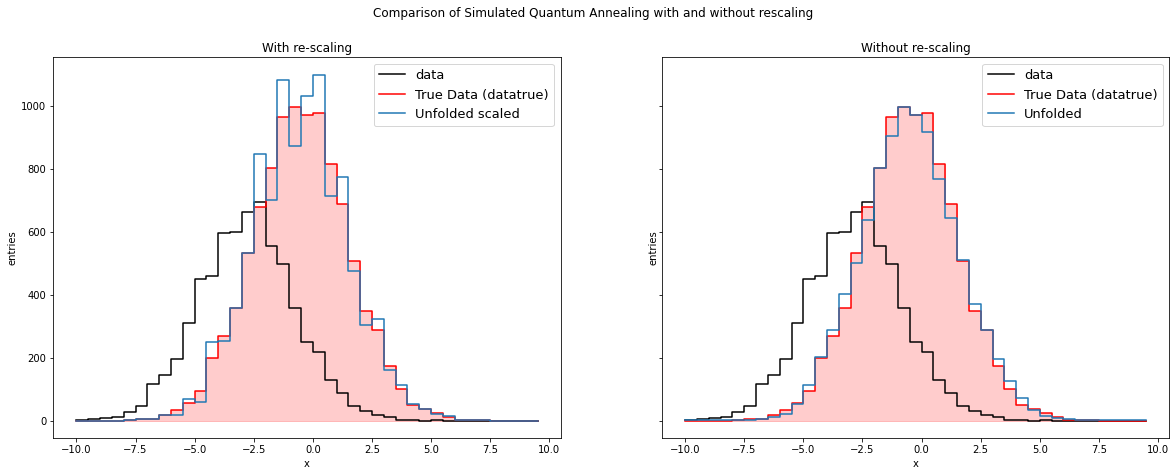

In [8]:
# plot
axis = xinipy_edges[0][:-1]

fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle("Comparison of Simulated Quantum Annealing with and without rescaling")

"""
Left hand side
"""
# plot what was measured
axs[0].step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
axs[0].step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
axs[0].fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
axs[0].step(axis, x_unfolded_scaling, fillstyle="bottom", label="Unfolded scaled")

axs[0].set_xlabel("x")
axs[0].set_ylabel("entries")
axs[0].legend(prop={'size': 13})
axs[0].set_title("With re-scaling")

"""
Right hand side
"""
# plot what was measured
axs[1].step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
axs[1].step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
axs[1].fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
axs[1].step(axis, x_unfolded_normal, fillstyle="bottom", label="Unfolded")

axs[1].set_xlabel("x")
axs[1].set_ylabel("entries")
axs[1].legend(prop={'size': 13})
axs[1].set_title("Without re-scaling")

### Simulated Annealing
Now, compare simulated annealing

In [9]:
# Unfold the rescaled histograms
unfolder_rescaled = QUBOUnfolder(
    datatruepy_for_encoding, rescaled_A, rescaled_datapy, n_bits=4, weight_regularization=0.8
)
# Unfold
x_unfolded = unfolder_rescaled.solve(
    backends.SimulatedAnnealingBackend(100)
)
# Descale and denormalize
x_unfolded_scaling = np.multiply(x_unfolded, xinipy)

In [10]:
# Unfold the normal histograms
# adding +1 to avoid division over zero
unfolder = QUBOUnfolder(
    datatruepy+1, Adetpy, datapy, n_bits=4, weight_regularization=0.5
)
# Unfold
x_unfolded_normal = unfolder.solve(
    backends.SimulatedAnnealingBackend(100)
)

Text(0.5, 1.0, 'Without re-scaling')

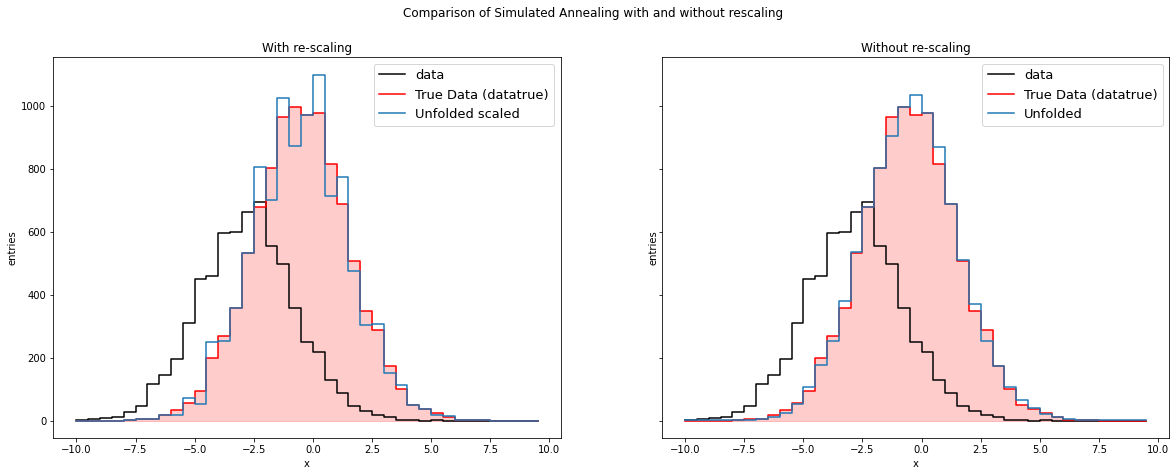

In [11]:
# plot
axis = xinipy_edges[0][:-1]

fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle("Comparison of Simulated Annealing with and without rescaling")

"""
Left hand side
"""
# plot what was measured
axs[0].step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
axs[0].step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
axs[0].fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
axs[0].step(axis, x_unfolded_scaling, fillstyle="bottom", label="Unfolded scaled")

axs[0].set_xlabel("x")
axs[0].set_ylabel("entries")
axs[0].legend(prop={'size': 13})
axs[0].set_title("With re-scaling")

"""
Right hand side
"""
# plot what was measured
axs[1].step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
axs[1].step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
axs[1].fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
axs[1].step(axis, x_unfolded_normal, fillstyle="bottom", label="Unfolded")

axs[1].set_xlabel("x")
axs[1].set_ylabel("entries")
axs[1].legend(prop={'size': 13})
axs[1].set_title("Without re-scaling")